In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import io
import glob

def collector(path):
    '''Collects all IDL save data from a given path and stores each file as an element in a list.'''
    
    filenames = glob.glob(path)
    
    data = {'data':[scipy.io.readsav(filenames[i],python_dict=True) \
            for i in range(len(filenames))],'filenames':filenames}
    return data

def separator(data):
    '''Compiles data into separate lists of extended and point sources'''

    point_data = [[data['data'][i]['source_array'][j] \
        for j in range(len(data['data'][i]['source_array'])) \
        if data['data'][i]['source_array'][j][-2] is None ] \
    for i in range(len(data['data']))]
    
    extended_data = [[data['data'][i]['source_array'][j] \
        for j in range(len(data['data'][i]['source_array'])) \
        if data['data'][i]['source_array'][j][-2] is not None ] \
    for i in range(len(data['data'])) ]

    return {'extsources':extended_data,'psources':point_data}

def pixelate(ra_zoom, dec_zoom, n_bins, ra_total, dec_total, flux_total):
    import numpy as np
    #Check to see which dimension is larger so that a square in ra,dec can 
    #be returned
    if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and dec that give the left side of each pixel
    ra_bin_array = (np.array(range(n_bins)) * binsize) + ra_zoom[0]
    dec_bin_array = (np.array(range(n_bins)) * binsize) + dec_zoom[0]
    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))

    #Histogram components into ra bins
    ra_histogram = np.digitize(ra_total,ra_bin_array)
    ###print ra_histogram

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array) - 2):
        ###print range(len(ra_bin_array) -2
        ###print "bin_i",bin_i
        #Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)
        ###print "rainds", ra_inds[0]
        ###print "lenrainds", len(ra_inds[0])

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds[0]) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by dec
        #print "dectotindex", dec_total[ra_inds]
        #print "decbin", dec_bin_array
        dec_histogram = np.digitize(dec_total[ra_inds],dec_bin_array)
        #print "dechist",dec_histogram
        #Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array) -2):
            
            #Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            #Go to next for cycle if no indices fall into current dec bin			
            if len(dec_inds[0]) == 0:
                continue
            #Sum the flux components that fall into current ra/dec bin
            ###print "bi",bin_i,bin_j
            ###print "inds",ra_inds, dec_inds
            pixels[bin_i,bin_j] = np.sum(flux_total[ra_inds[0][dec_inds][0]])

    #Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = (np.arange(n_bins) * binsize) + ra_zoom[0] + binsize/2.
    dec_pixel_centers = (np.arange(n_bins) * binsize) + dec_zoom[0] + binsize/2.

    return pixels, ra_pixel_centers, dec_pixel_centers

In [5]:
alldata = collector('diffuse_survey_source_arrays/*_source_array.sav')

In [53]:
alldata2 = collector('New_Source_Arrays/*_source_array.sav')

In [86]:
def plotEO(data,minI=3,sumI=50,binwidth=5,sigmawidth=15,EOid=None):
    from matplotlib.colors import LogNorm
    from matplotlib.colorbar import Colorbar
    import matplotlib.patches as patches
    from scipy.stats import iqr
    import matplotlib.gridspec as gridspec
    import re
    from astropy.convolution import convolve, convolve_fft
    from astropy.convolution import Gaussian2DKernel
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    import matplotlib.mlab as mlab
    
    separated = separator(data)
    
    binwidth = binwidth * (1./3600.) #Converting binwidth in arcsec to degrees
    sigmawidth = sigmawidth * (1./3600.) #Converting binwidth in arcsec to degrees
    
    indexed_point_sources_RA = [[separated['psources'][i][j]['RA'] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_point_sources_DEC = [[separated['psources'][i][j]['DEC'] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_point_sources_I = [[separated['psources'][i][j]['FLUX']['I'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]
    
    indexed_point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]
    
    indexed_point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0] \
        for j in range(len(separated['psources'][i]))] \
            for i in range(len(separated['psources'])) ]

    indexed_EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]

    indexed_EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    indexed_EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    indexed_EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0] \
        for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX'])) ] \
            for j in range(len(separated['extsources'][i]))] \
                for i in range(len(separated['extsources'])) ]
    
    for i in range(len(data['data'])):
        for j in range(len(indexed_EO_sources_RA[i])):
            for k in range(len(indexed_EO_sources_RA[i][j])):
                if indexed_EO_sources_RA[i][j][k] > 180:
                    indexed_EO_sources_RA[i][j][k] -= 360
        for j in range(len(indexed_point_sources_RA[i])):
            if indexed_point_sources_RA[i][j] > 180:
                indexed_point_sources_RA[i][j] -= 360    
    
    all_RA = [[indexed_point_sources_RA[i][j] \
        for j in range(len(indexed_point_sources_RA[i]))] \
        + [indexed_EO_sources_RA[i][j][k] \
        for j in range(len(indexed_EO_sources_RA[i])) \
        for k in range(len(indexed_EO_sources_RA[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_DEC = [[indexed_point_sources_DEC[i][j] \
        for j in range(len(indexed_point_sources_DEC[i]))] \
        + [indexed_EO_sources_DEC[i][j][k] \
        for j in range(len(indexed_EO_sources_DEC[i])) \
        for k in range(len(indexed_EO_sources_DEC[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_I = [[indexed_point_sources_I[i][j] \
        for j in range(len(indexed_point_sources_I[i]))] \
        + [indexed_EO_sources_I[i][j][k] \
        for j in range(len(indexed_EO_sources_I[i])) \
        for k in range(len(indexed_EO_sources_I[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_XX = [[indexed_point_sources_XX[i][j] \
        for j in range(len(indexed_point_sources_XX[i]))] \
        + [indexed_EO_sources_XX[i][j][k] \
        for j in range(len(indexed_EO_sources_XX[i])) \
        for k in range(len(indexed_EO_sources_XX[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_YY = [[indexed_point_sources_YY[i][j] \
        for j in range(len(indexed_point_sources_YY[i]))] \
        + [indexed_EO_sources_YY[i][j][k] \
        for j in range(len(indexed_EO_sources_YY[i])) \
        for k in range(len(indexed_EO_sources_YY[i][j]))] \
            for i in range(len(data['data'])) ]
    
    all_beam = [np.asarray(np.asarray(all_XX[i]) + np.asarray(all_YY[i])) / np.asarray(all_I[i]) for i in range(len(data['data']))]
    #print all_beam[0]
    #print all_beam[1]
    
    kernel = Gaussian2DKernel(stddev=(sigmawidth/binwidth))
    semi_zoom = 3
    pixelreplacement = 1e-4
    cmap = matplotlib.cm.get_cmap('gist_heat')

    for i in range(len(data['data'])):
        
        #---------- Pixelating and convolving All Plot
        all_ra_zoom = [min(all_RA[i]),max(all_RA[i])]
        all_dec_zoom = [min(all_DEC[i]),max(all_DEC[i])]
        all_n_bins = min(int(max(max(all_RA[i]) - min(all_RA[i]),max(all_DEC[i]) - min(all_DEC[i])) / binwidth),1024)
        all_ra_total = np.array(all_RA[i])
        all_dec_total = np.array(all_DEC[i])
        all_I_total = np.array(all_I[i])
        all_XX_total = np.array(all_XX[i])
        all_YY_total = np.array(all_YY[i])
        
        all_beam_total = np.array(all_beam[i])
        
        (all_pixels, all_ra_pixel_centers, all_dec_pixel_centers) = \
                pixelate(all_ra_zoom,all_dec_zoom,all_n_bins,all_ra_total,all_dec_total,all_I_total)
            
        (all_pixels_contour, all_ra_pixel_centers_contour, all_dec_pixel_centers_contour) = \
                    pixelate(all_ra_zoom,all_dec_zoom,50,all_ra_total,all_dec_total,all_beam_total)
        
        all_pixels[all_pixels == 0] = pixelreplacement
        all_convolved = convolve_fft(all_pixels, kernel)
        if EOid != None:
            minI, sumI = 0, 0
            
        
        for j in range(len(separated['extsources'][i])):
            if (EOid is not None) and (separated['extsources'][i][j]['ID'] != EOid):
                continue
                
            elif ((max(indexed_EO_sources_I[i][j]) > minI) or (sum(indexed_EO_sources_I[i][j]) > sumI))\
            and ((max(indexed_EO_sources_XX[i][j]) != 0) and (max(indexed_EO_sources_YY[i][j]) != 0)):
                #---------- Pixelating and convolving EO Plot
                EO_ra_zoom = [min(indexed_EO_sources_RA[i][j]),max(indexed_EO_sources_RA[i][j])]
                EO_dec_zoom = [min(indexed_EO_sources_DEC[i][j]),max(indexed_EO_sources_DEC[i][j])]                
                EO_ra_total = np.array(indexed_EO_sources_RA[i][j])
                EO_dec_total = np.array(indexed_EO_sources_DEC[i][j])
                EO_I_total = np.array(indexed_EO_sources_I[i][j])
                
                EO_n_bins = int(max(max(EO_ra_total) - min(EO_ra_total),max(EO_dec_total) - min(EO_dec_total)) / binwidth)
                print EO_n_bins
                print separated['extsources'][i][j]['ID']
                (EO_pixels, EO_ra_pixel_centers, EO_dec_pixel_centers) = \
                pixelate(EO_ra_zoom,EO_dec_zoom,EO_n_bins,EO_ra_total,EO_dec_total,EO_I_total)
                
                EO_pixels[EO_pixels == 0] = pixelreplacement
                EO_convolved = convolve_fft(EO_pixels, kernel)
                #---------- Pixelating and convolving Semi Plot
                semi_ra_zoom = [min(indexed_EO_sources_RA[i][j])-semi_zoom,max(indexed_EO_sources_RA[i][j])+semi_zoom]
                semi_dec_zoom = [min(indexed_EO_sources_DEC[i][j])-semi_zoom,max(indexed_EO_sources_DEC[i][j])+semi_zoom]
                semi_n_bins = min(int(max([semi_ra_zoom[1]-semi_ra_zoom[0],semi_dec_zoom[1]-semi_dec_zoom[0]])/binwidth),512)
                semi_ra_total = np.array(all_RA[i])
                semi_dec_total = np.array(all_DEC[i])
                semi_flux_total = np.array(all_I[i])

                (semi_pixels, semi_ra_pixel_centers, semi_dec_pixel_centers) = \
                        pixelate(semi_ra_zoom,semi_dec_zoom,semi_n_bins,semi_ra_total,semi_dec_total,semi_flux_total)

                semi_pixels[semi_pixels == 0] = pixelreplacement
                semi_convolved = convolve_fft(semi_pixels, kernel)
                
                ############################################################################
                
                
                
                

                fig = plt.figure(figsize=(16.75+.45,9.75+.2))
                fig.suptitle('EO Source {} from ObsID {}'.format\
                    (separated['extsources'][i][j]['ID'],\
                    [int(s) for s in re.findall('\d+',data['filenames'][i])][0],\
                    separated['extsources'][i][j]['FREQ']), fontsize = 20)
                
                gs = gridspec.GridSpec(5, 10, height_ratios=[1,4,.25,.5,4], width_ratios=[4,.25,1,4,.25,1,4,1,1,.25])
                gs.update(left=0.05, right=0.95, bottom=0, top=0.9, wspace=0.05, hspace=0.05)

                ax1 = fig.add_subplot(gs[1,0])
                
                all_plot = ax1.imshow(np.transpose(all_convolved), \
                    norm = LogNorm(vmin=pixelreplacement),\
                    origin = "lower", interpolation = "none", cmap = cmap,\
                    extent = [ all_ra_pixel_centers[-1], all_ra_pixel_centers[0],\
                    all_dec_pixel_centers[0], all_dec_pixel_centers[-1]])
                
                contour_plot = ax1.contourf(np.transpose(all_pixels_contour),cmap=plt.cm.bone,alpha=.4,\
                    levels=np.linspace(min(all_beam_total), max(all_beam_total), 6),\
                    extent = [all_ra_pixel_centers[-1], all_ra_pixel_centers[0], \
                    all_dec_pixel_centers[0], all_dec_pixel_centers[-1]])
                
                ax1.clabel(contour_plot, fontsize=8, inline=False, colors='cyan', alpha = 1)
                
                ax1.add_patch(patches.Rectangle((min(EO_ra_pixel_centers),min(EO_dec_pixel_centers)), \
                    semi_zoom,semi_zoom,fill=False,color='cyan'))
                ax1.set_xlabel('RA')
                ax1.set_ylabel('DEC')
                ax1.tick_params(size = 6, labelsize = 10)
                ax1.minorticks_on()
                
                ax2 = fig.add_subplot(gs[1,3])
                semi_plot = ax2.imshow(np.transpose(semi_convolved), \
                    norm = LogNorm(vmin=pixelreplacement),\
                    origin = "lower", interpolation = "none", cmap = cmap,\
                    extent = [semi_ra_pixel_centers[-1], semi_ra_pixel_centers[0], \
                    semi_dec_pixel_centers[0], semi_dec_pixel_centers[-1]])
                ax2.add_patch(patches.Rectangle((min(EO_ra_pixel_centers),min(EO_dec_pixel_centers)), \
                    (max(EO_ra_pixel_centers)-min(EO_ra_pixel_centers)),\
                    (max(EO_dec_pixel_centers)-min(EO_dec_pixel_centers)),fill=False,color='yellow'))
                ax2.set_xlabel('RA')
                ax2.minorticks_on()
                
                
                ra_lim = [min(EO_ra_total),max(EO_ra_total)]
                dec_lim = [min(EO_dec_total),max(EO_dec_total)]
                if (max(EO_ra_total) - min(EO_ra_total)) > (max(EO_dec_total)-min(EO_dec_total)):
                    dec_lim = [min(EO_dec_total),max(EO_dec_total)+(max(EO_ra_total) - min(EO_ra_total)) - (max(EO_dec_total)-min(EO_dec_total))]
                elif (max(EO_ra_total) - min(EO_ra_total)) < (max(EO_dec_total)-min(EO_dec_total)):
                    ra_lim = [min(EO_ra_total),max(EO_ra_total)+(max(EO_dec_total)-min(EO_dec_total)) - (max(EO_ra_total) - min(EO_ra_total))]

                
                ax3 = fig.add_subplot(gs[1,6])
                EO_plot = ax3.imshow(np.transpose(EO_convolved), \
                    norm = LogNorm(vmin=pixelreplacement),\
                    origin = "lower", interpolation = "none", cmap = cmap,\
                    extent = [EO_ra_pixel_centers[-1], EO_ra_pixel_centers[0], \
                    EO_dec_pixel_centers[0], EO_dec_pixel_centers[-1]])
                
                ax3.set_title('Source ID: {}'.format(separated['extsources'][i][j]['ID']),fontsize=16)
                ax3.xaxis.set_ticks_position('none')
                ax3.yaxis.set_ticks_position('none')
                ax3.set_xlabel(r' ')
                ax3.set_ylabel(r' ')
                ax3.set_xticklabels([])
                ax3.set_yticklabels([])
                ax3.set_xlabel(r'$\Delta$ {:.4G}%c '.format((max(EO_ra_total) - min(EO_ra_total))*60.), fontsize = 12)
                ax3.set_ylabel(r'$\Delta$ {:.4G}%c '.format((max(EO_dec_total) - min(EO_dec_total))*60.), fontsize = 12)
                
                #---------- Plotting Stokes Histograms
                stokes_hist_bins = 40
                
                ax4 = fig.add_subplot(gs[4,0])
                ax4.hist(indexed_EO_sources_I[i][j],bins=stokes_hist_bins, orientation='vertical', color='tomato', alpha=.75, edgecolor='k')
                ax4.set_title('EO Source: {} Stokes Intensity'.format(separated['extsources'][i][j]['ID']),fontsize=16)
                ax4.set_xlabel(r'I')
                ax4.set_ylabel(r'Number of Sources')
                ax4.xaxis.grid(which="major", color='grey', linestyle='--', linewidth=.75, alpha=.5)
                ax4.yaxis.grid(which="major", color='grey', linestyle='--', linewidth=.75, alpha=.5)
                
                ax5 = fig.add_subplot(gs[4,3])
                ax5.hist(indexed_EO_sources_XX[i][j],bins=stokes_hist_bins, orientation='vertical', color='green', alpha=.75, edgecolor='k')
                ax5.set_title('EO Source: {} Stokes XX'.format(separated['extsources'][i][j]['ID']),fontsize=16)
                ax5.set_xlabel(r'XX')
                ax5.set_ylabel(r'Number of Sources')
                ax5.xaxis.grid(which="major", color='grey', linestyle='--', linewidth=.75, alpha=.5)
                ax5.yaxis.grid(which="major", color='grey', linestyle='--', linewidth=.75, alpha=.5)
                
                ax6 = fig.add_subplot(gs[4,6])
                ax6.hist(indexed_EO_sources_YY[i][j],bins=stokes_hist_bins, orientation='vertical', color='teal', alpha=.75, edgecolor='k')
                ax6.set_title('EO Source: {} Stokes YY'.format(separated['extsources'][i][j]['ID']),fontsize=16)
                ax6.set_xlabel(r'YY')
                ax6.set_ylabel(r'Number of Sources')
                ax6.xaxis.grid(which="major", color='grey', linestyle='--', linewidth=.75, alpha=.5)
                ax6.yaxis.grid(which="major", color='grey', linestyle='--', linewidth=.75, alpha=.5)
                
                #---------- Plotting Circle
                
                d = (ra_lim[1]-ra_lim[0]) * 3600. / 60. #Degrees into arcmin
                r = d/2. #
                theta = 2.*np.pi
                
                dotter = fig.add_subplot(gs[0,7],projection='polar')
                circle = plt.Circle((0, 0), radius=r, transform=dotter.transData._b, color='r', alpha=0.4)
                dotter.set_rmax(50)
                dotter.set_rticks([r])
                dotter.set_xticklabels([50])
                dotter.set_rlabel_position(135)
                dotter.grid(False)
                dotter.add_artist(circle)
                
                #---------- Plotting imshow colorbars
                
                all_cbax = plt.subplot(gs[1,1])
                all_cb = Colorbar(ax = all_cbax, mappable = all_plot, orientation = 'vertical', ticklocation = 'right')
                #all_cb.set_label(r'Janskies', labelpad=10)
                
                semi_cbax = plt.subplot(gs[1,4])
                semi_cb = Colorbar(ax = semi_cbax, mappable = semi_plot, orientation = 'vertical', ticklocation = 'right')
                #semi_cb.set_label(r'Janskies', labelpad=10)
                
                EO_cbax = plt.subplot(gs[1,9])
                EO_cb = Colorbar(ax = EO_cbax, mappable = EO_plot, orientation = 'vertical', ticklocation = 'right')
                EO_cb.set_label(r'Janskies', labelpad=10)
                
                
                #---------- Plotting RA and DEC histograms for EO Plot
                
                EO_hist_ra = plt.subplot(gs[0,6])
                EO_hist_dec = plt.subplot(gs[1,7])
                
                EO_hist_ra_bins = np.arange(ra_lim[0],ra_lim[1],max(binwidth,.01))
                EO_hist_dec_bins = np.arange(dec_lim[0],dec_lim[1],max(binwidth,.01))
                
                
                EO_hist_ra.hist(EO_ra_total,bins=EO_hist_ra_bins, orientation='vertical', color='k', edgecolor='w')
                EO_hist_ra.set_xlim(ra_lim[1],ra_lim[0])
                EO_hist_ra.set_xticks(np.linspace(ra_lim[0],ra_lim[1],5))
                EO_hist_ra.set_yticklabels([])
                EO_hist_ra.set_xlabel(r'RA')
                EO_hist_ra.xaxis.set_label_position('top')
                
                EO_hist_ra.xaxis.tick_top()
                EO_hist_ra.tick_params(axis='x', which='both', bottom='off',top='on',labelbottom='off')
                EO_hist_ra.yaxis.set_ticks_position('none')
                EO_hist_ra.minorticks_on()
                EO_hist_ra.xaxis.grid(which="major", color='k', linestyle='--', linewidth=.75, alpha=.75)
                EO_hist_ra.xaxis.grid(which="minor", color='k', linestyle='--', linewidth=.5, alpha=.5)
                                #EO_hist_ra.set_ylim(EO_hist_ra.get_ylim()[::-1])
                
                EO_hist_dec.hist(EO_dec_total,bins=EO_hist_dec_bins, orientation='horizontal', color='k', edgecolor='w')
                EO_hist_dec.set_xlim()
                EO_hist_dec.set_ylim(dec_lim)
                EO_hist_dec.set_yticks(np.linspace(dec_lim[0],dec_lim[1],5))
                EO_hist_dec.set_xticklabels([])
                EO_hist_dec.set_ylabel(r'DEC')
                EO_hist_dec.yaxis.tick_right()
                EO_hist_dec.xaxis.set_ticks_position('none')
                EO_hist_dec.tick_params(axis='y', which='both', left='off',right='on')
                EO_hist_dec.minorticks_on()
                EO_hist_dec.yaxis.grid(which="major", color='k', linestyle='--', linewidth=.75, alpha=.75)
                EO_hist_dec.yaxis.grid(which="minor", color='k', linestyle='--', linewidth=.5, alpha=.5)
                
                ###################################################

                databox1 = plt.subplot(gs[4,0])
                databox2 = plt.subplot(gs[4,3])
                
                databox1.annotate("Source ID: {}\nEO Source Count: {}\nMean RA: {}\nMean Dec: {}".format \
                    (separated['extsources'][i][j]['ID'],\
                    len(indexed_EO_sources_I[i][j]),\
                    "{:.4G}".format(np.mean(indexed_EO_sources_RA[i][j])),\
                    "{:.4G}".format(np.mean(indexed_EO_sources_DEC[i][j]))),\
                    xy=(0, .9), xytext=(0, 0), xycoords=('axes fraction', 'figure fraction'),\
                    textcoords='offset points', size=12, ha='left', va='top',)
                    #bbox=dict(boxstyle="square", fc="w"))
                    
                databox2.annotate("Highest Intensity: {}\nTotal Intensity: {}\nTotal XX: {}\nTotal YY: {}\n".format\
                    ("{:.4G}".format(np.max(indexed_EO_sources_I[i][j])),\
                    "{:.4G}".format(np.sum(indexed_EO_sources_I[i][j])),\
                     "{:.4G}".format(np.sum(indexed_EO_sources_XX[i][j])),\
                     "{:.4G}".format(np.sum(indexed_EO_sources_YY[i][j]))),\
                    xy=(0, .9), xytext=(0, 0), xycoords=('axes fraction', 'figure fraction'),\
                    textcoords='offset points', size=12, ha='left', va='top',)
                
                plt.savefig('/home/champ6/uwchamp2017/EOplots/EO'+'{}'.format(separated['extsources'][i][j]['ID'])+'.png', bbox_inches='tight')
    return plt.show()

771
32768
1098
32769
627
32772
167
32775
496
32777
190
32778
99
32779
271
32785
338
27037
383
28458
124
28460


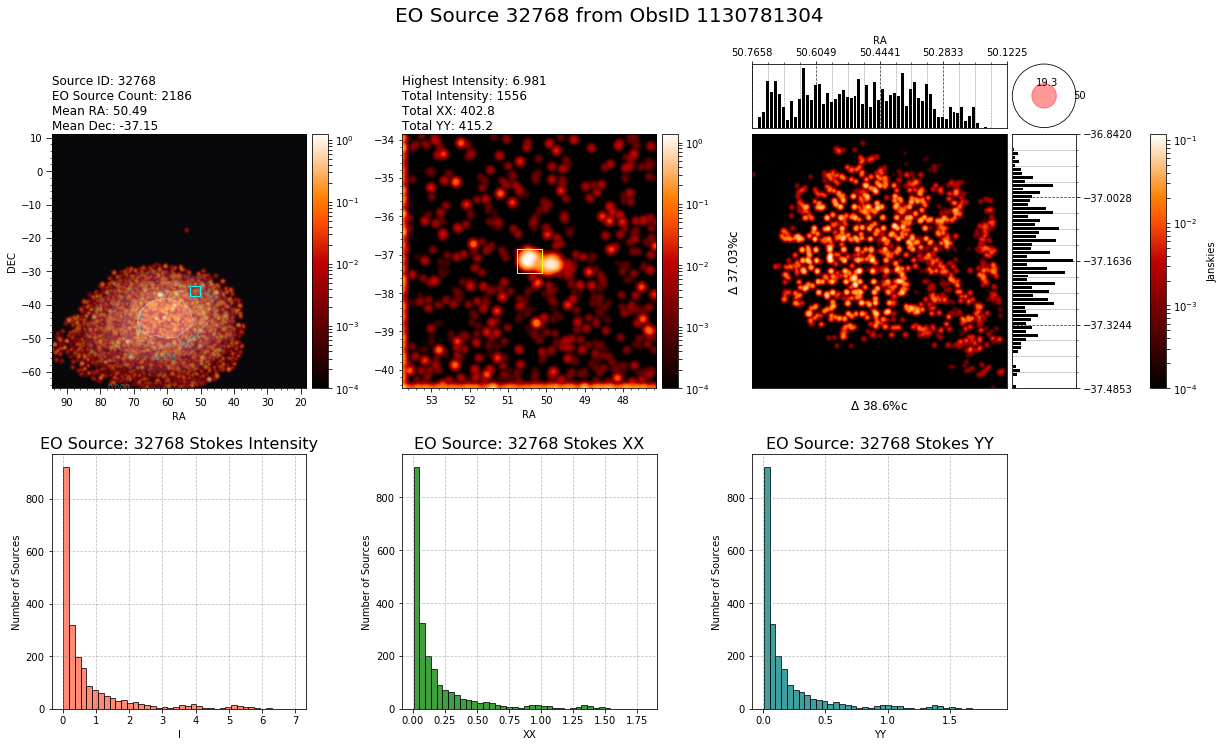

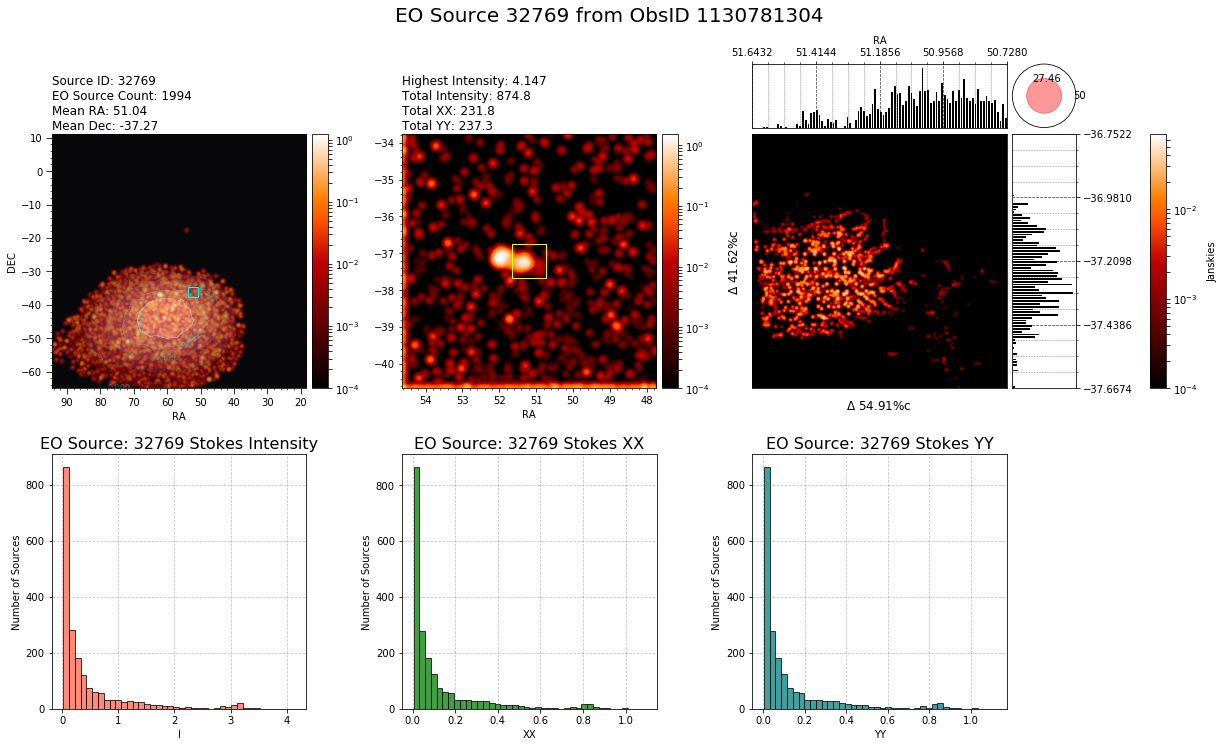

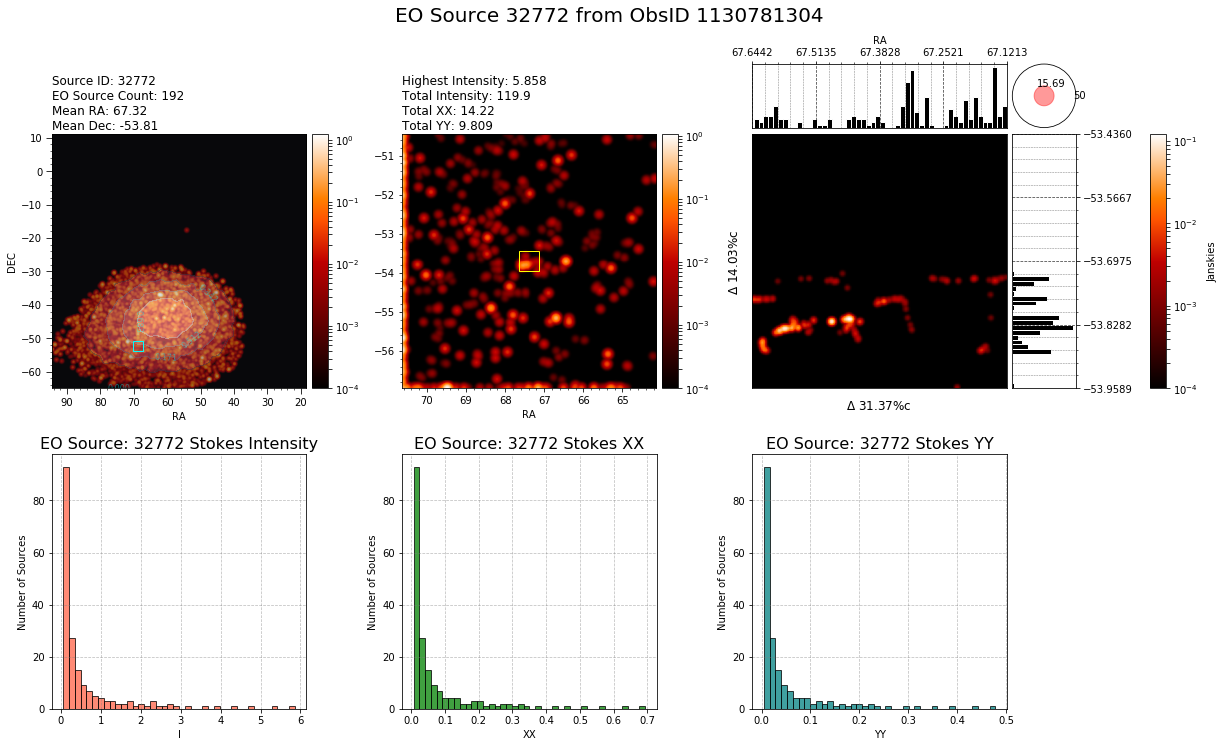

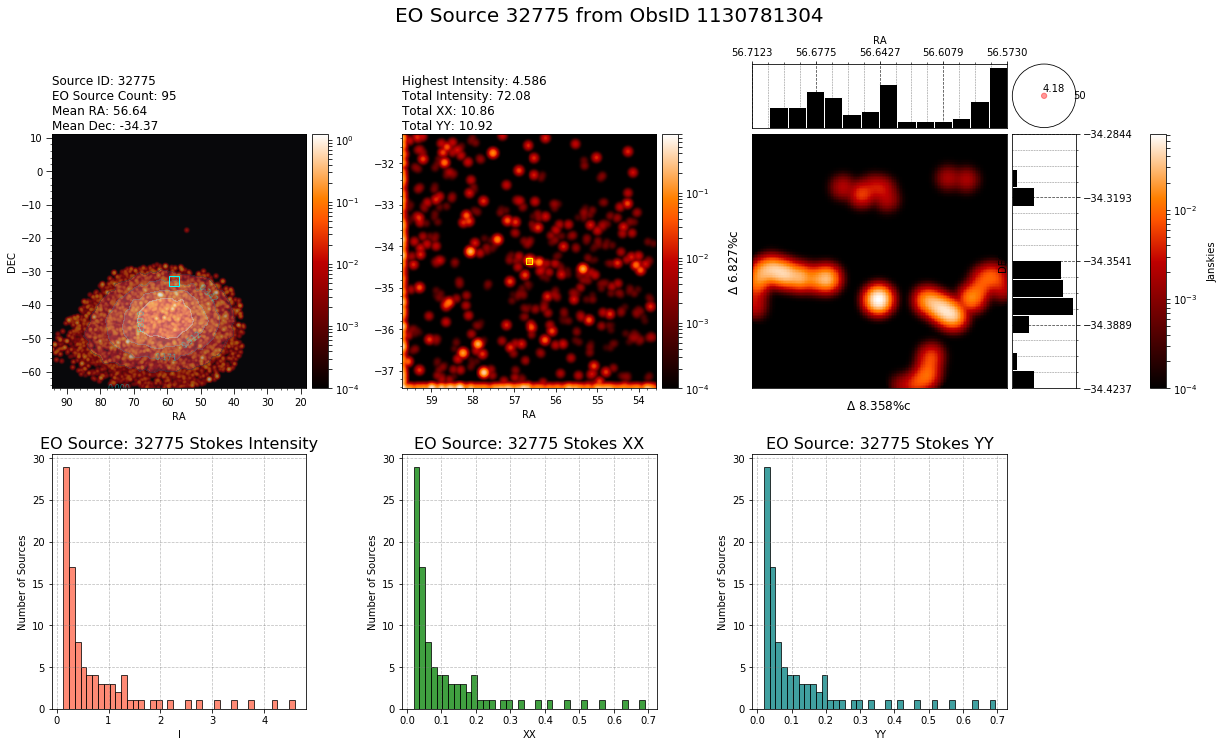

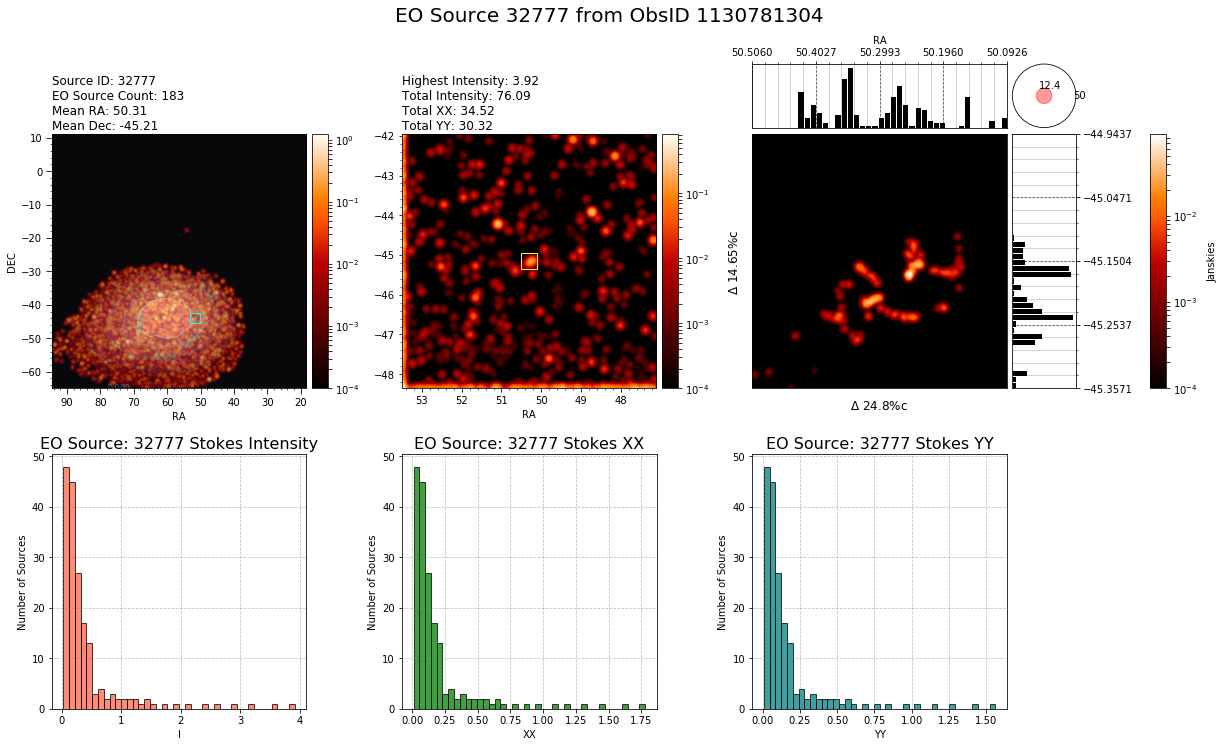

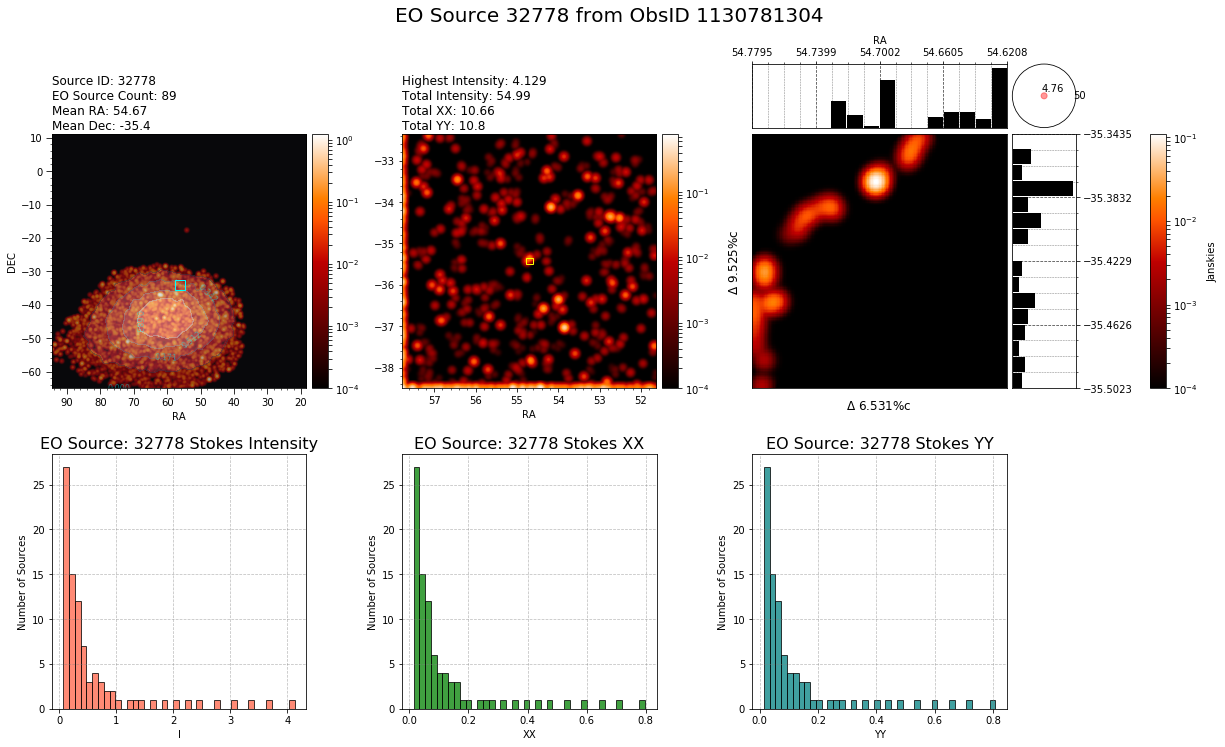

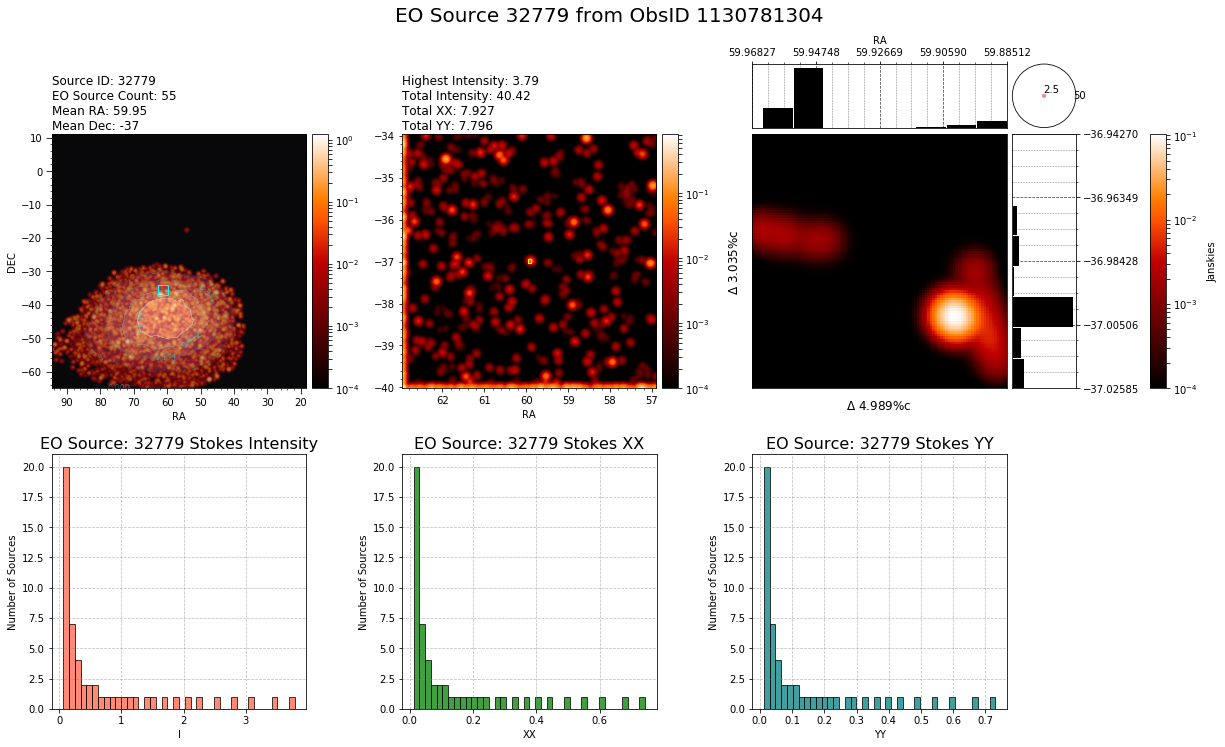

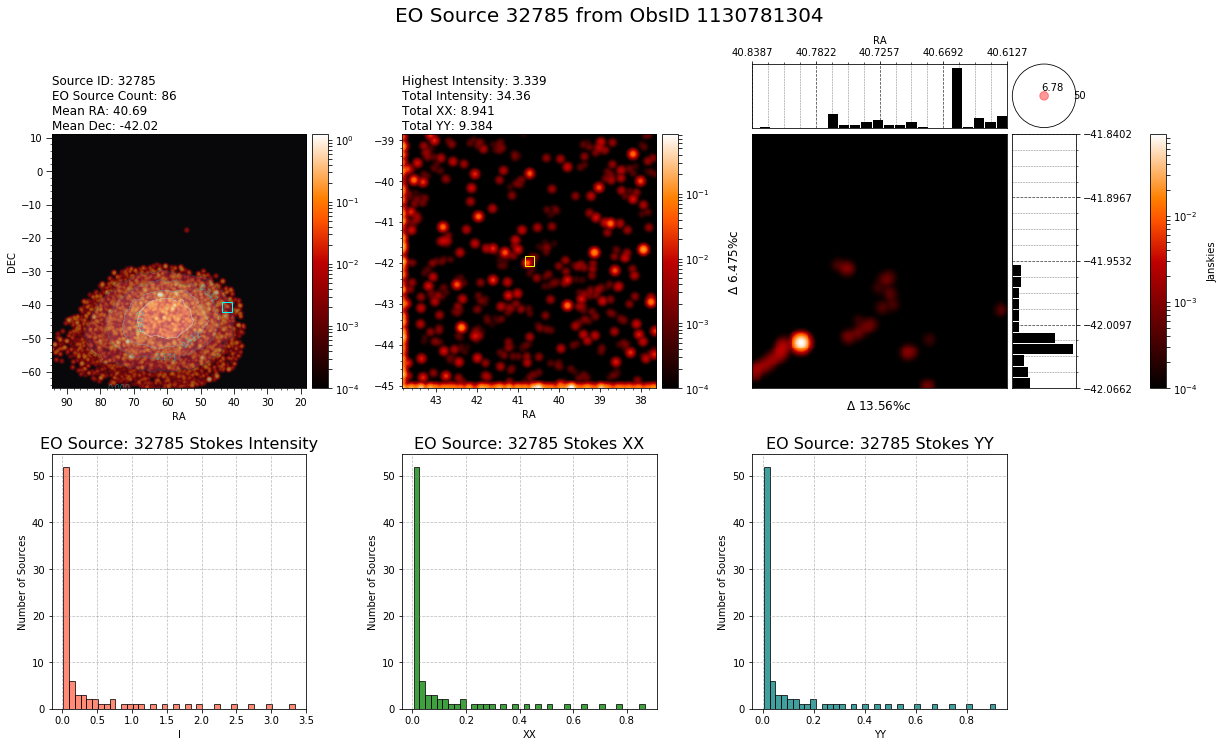

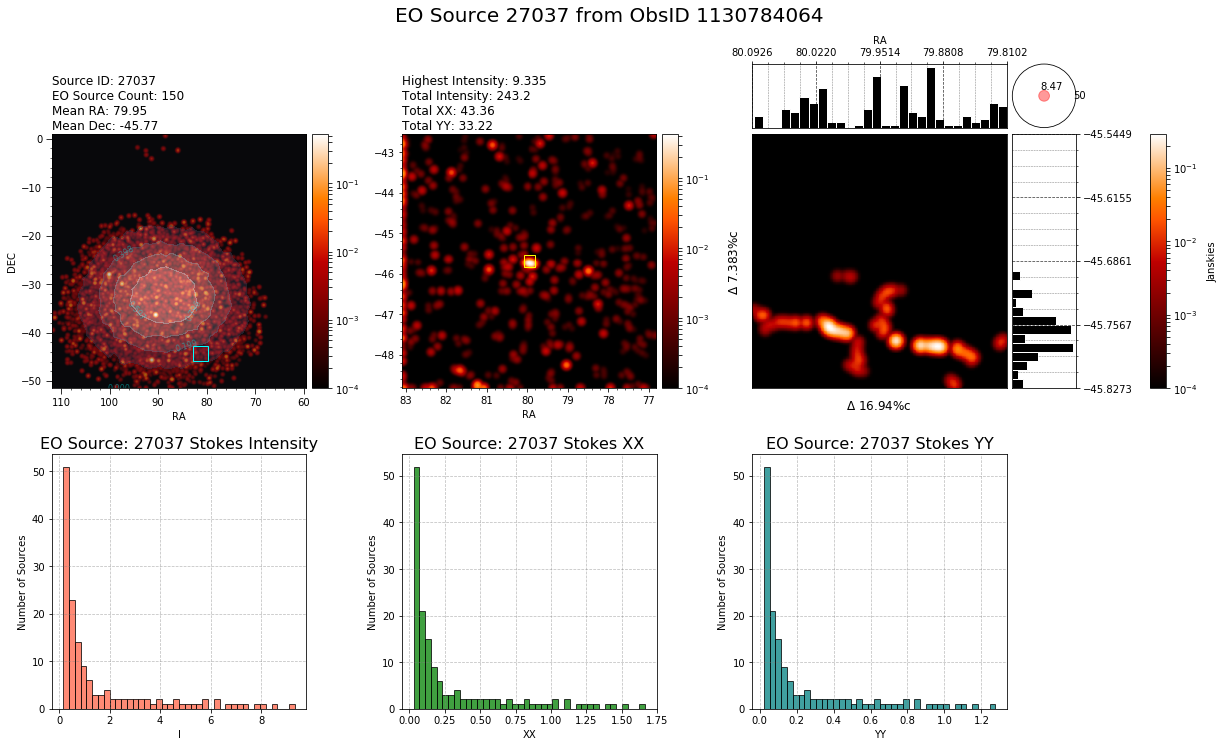

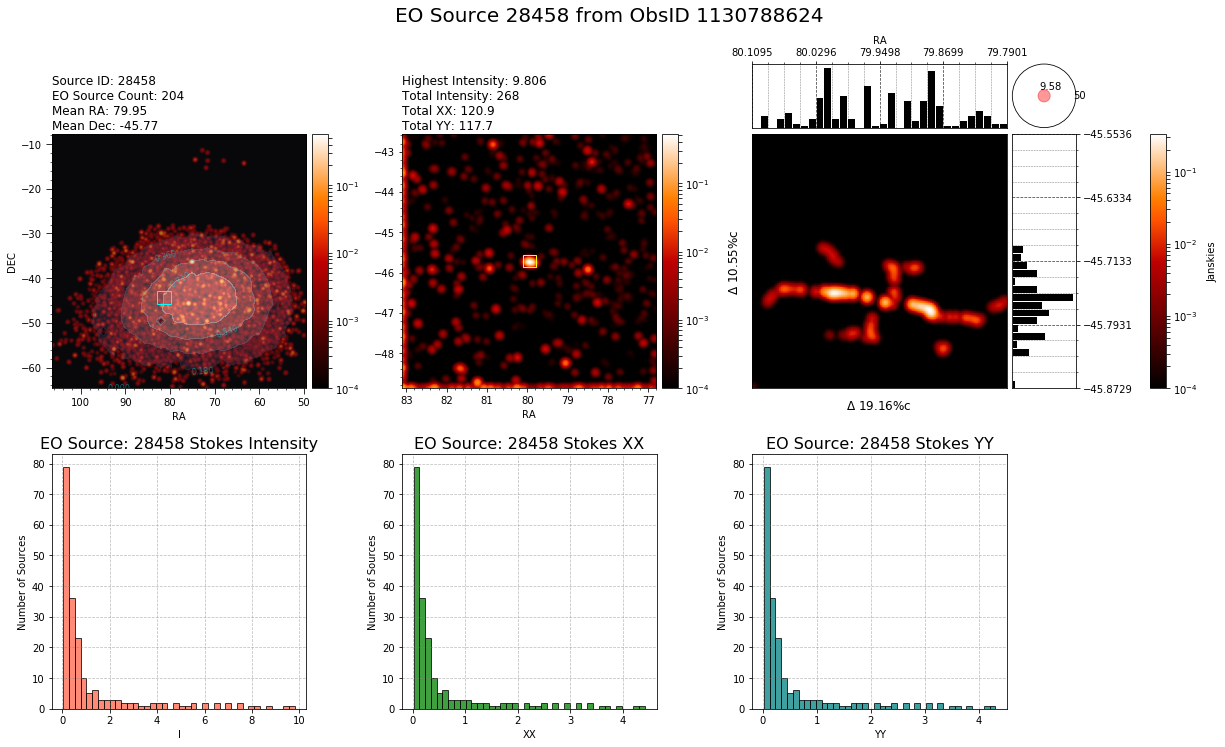

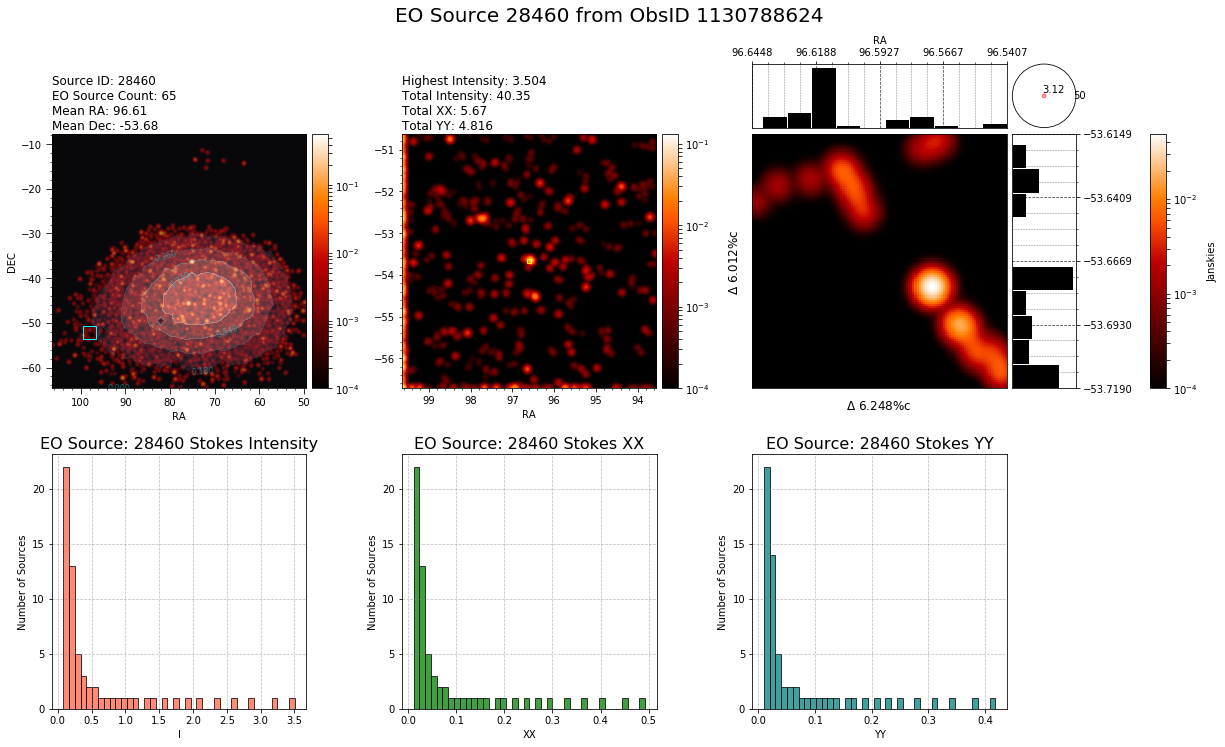

In [90]:
plotEO(alldata2,binwidth=3,sigmawidth=12)

In [ ]:
fornax = collector('diffuse_survey_source_arrays/1130781304_source_array.sav')

In [3]:
compact = collector('diffuse_survey_source_arrays/1131557504_source_array.sav')

In [ ]:
for i in range(20,401,40):
    plotEO(alldata,8,1000,i)

In [ ]:
print [int(s) for s in re.findall('\d+',alldata['filenames'][2])][0]